# 1. Imports, custom functions, etc.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from xgboost import XGBClassifier

import warnings
import pickle
import joblib
import optuna
import shutil
import glob
import json
import gc

warnings.filterwarnings("ignore")

In [2]:
class configs:

    train_path = "playground-series-s5e6/train.csv"
    test_path = "playground-series-s5e6/test.csv"
    original_path = "playground-series-s5e6/Fertilizer Prediction.csv"
    sample_sub_path = "playground-series-s5e6/sample_submission.csv"

    target = "Fertilizer Name"
    n_folds = 5
    seed = 42

In [3]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [4]:
class Trainer:
    def __init__(self, model, config=configs):
        self.model = model
        self.config = config
        self.fitted_model = None  # Will hold the best model

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        best_score = -np.inf  # For tracking the best fold model
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if X_original is not None and y_original is not None:
                X_train = pd.concat([X_train, X_original])
                y_train = pd.concat([y_train, y_original])
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)

            if score > best_score:
                best_score = score
                self.fitted_model = model

            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        # Save the best model using joblib
        #if self.fitted_model is not None:
        #    model_name = self.fitted_model.__class__.__name__
        #    filename = f"best_model_{model_name}.pkl"
        #    joblib.dump(self.fitted_model, filename)
        #    print(f"✅ Best model saved to: {filename}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):
        scores = []
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

# 2. Load required datasets

In [5]:
# Load train & test data
train = pd.read_csv(configs.train_path, index_col="id")
test = pd.read_csv(configs.test_path, index_col="id")
original = pd.read_csv(configs.original_path)

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != "Fertilizer Name"]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")
original[cat_cols] = original[cat_cols].astype(str).astype("category")

# Encode target "Fertilizer Name"
label_encoder = LabelEncoder()
train[configs.target] = label_encoder.fit_transform(train[configs.target])
original[configs.target] = label_encoder.transform(original[configs.target])

X = train.drop(configs.target, axis=1)
y = train[configs.target]
X_test = test

# 3. Load oof_preds & test_preds from previous

In [6]:
# Load OOF preds from .pkl
with open("oof_preds_full.pkl", "rb") as f:
    oof_pred_probs = pickle.load(f)

# Load Test preds from .pkl
with open("test_preds_full.pkl", "rb") as f:
    test_pred_probs = pickle.load(f)

# Validate dictionary keys of loaded predictions
print("Keys in oof_pred_probs:", list(oof_pred_probs.keys()))
print("Keys in test_pred_probs:", list(test_pred_probs.keys()))

# Validate shape of loaded precitions
print("\nShapes of OOF Predictions:")
for model_name, preds in oof_pred_probs.items():
    print(f"{model_name}: {preds.shape}")

print("\nShapes of Test Predictions:")
for model_name, preds in test_pred_probs.items():
    print(f"{model_name}: {preds.shape}")

Keys in oof_pred_probs: ['LightGBM (gbdt)', 'LightGBM (goss)', 'XGBoost', 'AutoGluon', 'TabTransformer']
Keys in test_pred_probs: ['LightGBM (gbdt)', 'LightGBM (goss)', 'XGBoost', 'AutoGluon', 'TabTransformer']

Shapes of OOF Predictions:
LightGBM (gbdt): (750000, 7)
LightGBM (goss): (750000, 7)
XGBoost: (750000, 7)
AutoGluon: (750000, 7)
TabTransformer: (750000, 7)

Shapes of Test Predictions:
LightGBM (gbdt): (250000, 7)
LightGBM (goss): (250000, 7)
XGBoost: (250000, 7)
AutoGluon: (250000, 7)
TabTransformer: (250000, 7)


In [8]:
scores = {}

models = ["LightGBM (gbdt)", "LightGBM (goss)", "XGBoost", "AutoGluon", "TabTransformer"]
model_keys = {
    "LightGBM (gbdt)": "LightGBM (gbdt)",
    "LightGBM (goss)": "LightGBM (goss)",
    "XGBoost": "XGBoost",
    "AutoGluon": "AutoGluon",
    "TabTransformer": "TabTransformer"
}

skf = StratifiedKFold(n_splits=configs.n_folds, random_state=configs.seed, shuffle=True)

for model in models:
    fold_scores = []
    preds = oof_pred_probs[model_keys[model]]
    
    for _, val_idx in skf.split(X, y):
        fold_score = map3(y[val_idx], preds[val_idx])
        fold_scores.append(fold_score)

    scores[model] = fold_scores

In [9]:
# Define training & testing sets from oof_pred_probs & test_pred_probs
X_ensemble = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X_ensemble_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

# 4. Define Logistic Regression Model

In [10]:
#scores = {}

lr_model = LogisticRegression(
    random_state=42, 
    max_iter=1000, 
    solver='liblinear', 
    penalty='l2', 
    C=32.89802104596641,
    tol=0.0029878837974181643,
    fit_intercept=True
)

lr_trainer = Trainer(lr_model)
_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X_ensemble, y, X_ensemble_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.366181
--- Fold 2 - MAP@3: 0.367057
--- Fold 3 - MAP@3: 0.369009
--- Fold 4 - MAP@3: 0.367234
--- Fold 5 - MAP@3: 0.367124

------ Overall MAP@3: 0.367321 | Average MAP@3: 0.367321 ± 0.000924


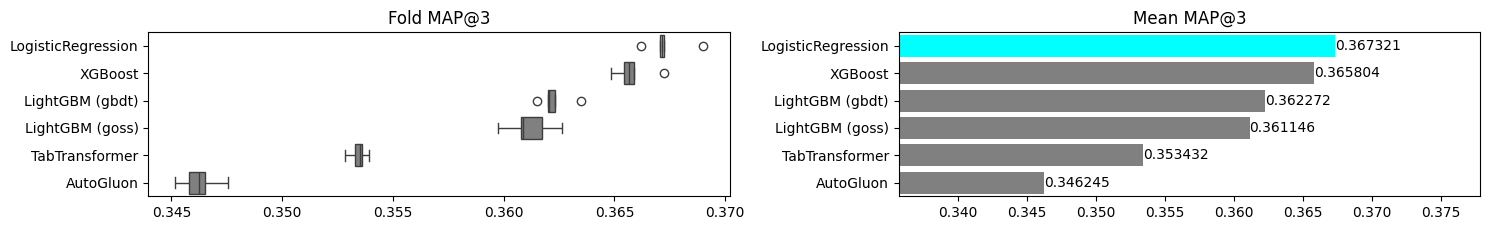

In [12]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()